In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,pickle
import neurokit2 as nk
from glob import glob
import math
sns.set_style("whitegrid")

# Feature extraction: Chest
Train subjects: 2-13 (except 12)

Test subjects: 14,15,16,17

Total of 42 features extracted

In [ ]:
import warnings
from itertools import zip_longest

DATA_PATH = "./WESAD"
fs_chest = 700
win_sec = 60
shift_sec = 30
subjects = [s for s in range(2, 18) if s != 12]
train_subjects = [s for s in range(2, 14) if s != 12]
test_subjects  = [s for s in range(14, 18)]

# Suppress DFA warnings
warnings.filterwarnings("ignore", message="DFA_alpha2")

# Rolling window
def segment_signal(signal, labels, label_value, fs, win_sec, shift_sec):
    mask = labels == label_value
    sig = signal[mask].squeeze()
    n = len(sig)
    win_len = win_sec * fs
    step = shift_sec * fs
    for start in range(0, n - win_len + 1, step):
        yield sig[start:start + win_len]

# ECG features 
def extract_ecg_features(ecg_seg, fs):
    ecg_cleaned = nk.ecg_clean(ecg_seg, sampling_rate=fs)
    _, info = nk.ecg_process(ecg_cleaned, sampling_rate=fs)
    # Compute HRV time + frequency metrics
    peaks = info['ECG_R_Peaks']
    hrv_time = nk.hrv_time(peaks, sampling_rate=fs)
    hrv_freq = nk.hrv_frequency(peaks, sampling_rate=fs, psd_method='welch',ulf=(0, 0.01), vlf=(0.01, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4), vhf=(0.4, 1.0))
    return {"HRV_mean_NN": hrv_time["HRV_MeanNN"].iloc[0],
        "HRV_sdNN": hrv_time["HRV_SDNN"].iloc[0],
        "HRV_pNN50": hrv_time["HRV_pNN50"].iloc[0],
        "HRV_TINN": hrv_time["HRV_TINN"].iloc[0],
        "HRV_RMSSD": hrv_time["HRV_RMSSD"].iloc[0],
        #"HRV_ULF": hrv_freq["HRV_VLF"].iloc[0],
        "HRV_LF": hrv_freq["HRV_LF"].iloc[0],
        "HRV_HF": hrv_freq["HRV_HF"].iloc[0],
        "HRV_UHF": hrv_freq["HRV_VHF"].iloc[0],
        "HRV_LF/HF": hrv_freq["HRV_LFHF"].iloc[0],
        "HRV_total_power": hrv_freq["HRV_TP"].iloc[0],
        "HRV_LFnorm": hrv_freq["HRV_LFn"].iloc[0],
        "HRV_HFnorm": hrv_freq["HRV_HFn"].iloc[0]
    }


# EDA features
def extract_eda_features(eda_seg, fs):
    signals, info = nk.eda_process(eda_seg, sampling_rate=fs)
    eda_clean = signals["EDA_Clean"]
    phasic = signals["EDA_Phasic"]
    tonic = signals["EDA_Tonic"]
    time_vector = np.arange(len(eda_clean)) / fs
    coefficients = np.polyfit(time_vector, eda_clean, 1)
    slope_EDA = coefficients[0]
    fea=nk.eda_analyze(signals, sampling_rate=fs)
    #========
    #scr_peaks, _ = nk.eda_peaks(eda_clean, sampling_rate=fs)
    #scr_rate = scr_peaks["SCR_Peaks"].sum() / (len(eda_clean)/fs) * 60  # per min
    return {
        "EDA_mean": np.mean(eda_clean),
        "EDA_std": np.std(eda_clean),
        "EDA_max": np.max(eda_clean),
        "EDA_min": np.min(eda_clean),
        "EDA_slope": slope_EDA,
        "EDA_range": np.max(eda_clean) - np.min(eda_clean),
        "SCR_mean_amp": np.mean(phasic),
        "SCR_std_amp": np.std(phasic),
        "SCL_mean": np.mean(tonic),
        "SCL_std": np.std(tonic),
        "SCL_correlation": fea["EDA_Autocorrelation"].iloc[0],
        "SCR_num_peaks": np.sum(signals["SCR_Peaks"]),
        "SCR_peaks_amplitude_mean": fea['SCR_Peaks_Amplitude_Mean'].iloc[0]
        }

# RESP features 
def extract_resp_features(rsp_seg, fs):
    signals,info = nk.rsp_process(rsp_seg, sampling_rate=fs)
    fea = nk.rsp_analyze(signals, sampling_rate=fs)
    return {
        "RSP_inhale_duration_mean": fea['RSP_Phase_Duration_Inspiration'].iloc[0],
        "RSP_exhale_duration_mean": fea['RSP_Phase_Duration_Expiration'].iloc[0],
        "RSP_IE_ratio": fea['RSP_Phase_Duration_Ratio'].iloc[0],
        "RSP_Amp": signals['RSP_Amplitude'].iloc[0],
        "RSP_Vol": signals['RSP_RVT'].iloc[0],
        "RSP_breath_rate": fea['RSP_Rate_Mean'].iloc[0]
        }

# TEMP features
def extract_temp_features(temp_seg,fs):
    time_vector = np.arange(len(temp_seg)) / fs
    coefficients = np.polyfit(time_vector, temp_seg, 1)
    slope_temp = coefficients[0]
    return {
        "TEMP_mean": np.mean(temp_seg),
        "TEMP_std": np.std(temp_seg),
        "TEMP_max": np.max(temp_seg),
        "TEMP_min": np.min(temp_seg),
        "TEMP_range": np.max(temp_seg) - np.min(temp_seg),
        "TEMP_slope": slope_temp
    }
# ---------- EMG features ----------(tbd)
def extract_emg_features(emg_seg, fs):
    #signals, info = nk.emg_process(emg_seg, sampling_rate=fs)
    #fea = nk.emg_analyze(signals)
    return {
        "EMG_Mean": np.mean(emg_seg),
        "EMG_Std": np.std(emg_seg),
        "EMG_range": np.ptp(emg_seg),
        "EMG_abs_int": np.sum(np.abs(emg_seg)),
        "EMG_median": np.median(emg_seg)#,
        #"EMG_#Peaks": fea['EMG_Activation_N'].iloc[0],
        #"EMG_Peak_Amplitude_Mean": fea['EMG_Amplitude_Mean'].iloc[0]
    }

# Unified feature extraction
def extract_features_from_subject(subj, label_value):
    fname = os.path.join(DATA_PATH, f"S{subj}", f"S{subj}.pkl")
    with open(fname, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    chest = data["signal"]["chest"]
    labels = np.asarray(data["label"])
    fs = fs_chest

    feats = []
    for i,(ecg_seg, eda_seg, rsp_seg, temp_seg, emg_seg) in enumerate(zip(
        segment_signal(chest["ECG"], labels, label_value, fs, win_sec, shift_sec),
        segment_signal(chest["EDA"], labels, label_value, fs, win_sec, shift_sec),
        segment_signal(chest["Resp"], labels, label_value, fs, win_sec, shift_sec),
        segment_signal(chest["Temp"], labels, label_value, fs, win_sec, shift_sec),
        segment_signal(chest["EMG"], labels, label_value, fs, win_sec, shift_sec))
    ):
        row = {}
        ecg_feat = extract_ecg_features(ecg_seg, fs)
        row.update(ecg_feat)
        eda_feat = extract_eda_features(eda_seg, fs)
        row.update(eda_feat)
        rsp_feat = extract_resp_features(rsp_seg, fs)
        row.update(rsp_feat)
        temp_feat = extract_temp_features(temp_seg,fs)
        row.update(temp_feat)
        emg_feat = extract_emg_features(emg_seg, fs)
        row.update(emg_feat)
        row["label"] = 0 if label_value == 1 else 1   # baseline=0, TSST=1
        row["subject"] = subj
        baseline_offset_sec = 0 if row["label"] == 0 else 20 * 60 # record window start time
        row["win_start_sec"] = i * shift_sec + baseline_offset_sec # record window start time
        feats.append(row)
    return pd.DataFrame(feats)



# Main train/test extraction
def get_train_test_features():
    train_dfs, test_dfs = [], []
    for subj in train_subjects + test_subjects:
        for lbl in [1, 2]:  # baseline, stress
            df = extract_features_from_subject(subj, lbl)
            if df.empty: continue
            (train_dfs if subj in train_subjects else test_dfs).append(df)
    train_df = pd.concat(train_dfs, ignore_index=True)
    test_df  = pd.concat(test_dfs,  ignore_index=True)
    print(f"Train: {train_df.shape}, Test: {test_df.shape}")
    return train_df, test_df

# Run 
train_df, test_df = get_train_test_features()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Columns:", train_df.columns.tolist()[:10], "...")
train_df.to_csv("train_features.csv", index=False)
test_df.to_csv("test_features.csv", index=False)
print("Feature extraction completed.")


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/neurokit2/rsp/rsp_rrv.py:210: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


Train: (639, 45), Test: (238, 45)
Train shape: (639, 45)
Test shape: (238, 45)
Columns: ['HRV_mean_NN', 'HRV_sdNN', 'HRV_pNN50', 'HRV_TINN', 'HRV_RMSSD', 'HRV_LF', 'HRV_HF', 'HRV_UHF', 'HRV_LF/HF', 'HRV_total_power'] ...
Feature extraction completed.


# Calibration

We use the first 2 minutes of the baseline condition to calibrate each subject's data

In [14]:
def calibrate_subject(df, baseline_label=0, calibration_frac=2.0/20.0):
    # Separate baseline and stress data
    baseline_df = df[df['label'] == baseline_label]

    # Determine calibration window
    n_calib = int(round(calibration_frac * len(baseline_df)))
    calib_df = baseline_df.iloc[:n_calib, :]

    # Identify feature columns (exclude label, subject, start_time)
    feature_cols = [c for c in df.columns if c not in ['label', 'subject', 'win_start_sec']]

    # Compute mean and std from baseline calibration window
    mean_vals = calib_df[feature_cols].mean()
    std_vals = calib_df[feature_cols].std(ddof=0)

    # Apply normalization to all data using baseline calibration
    df_calibrated = df.copy()
    df_calibrated[feature_cols] = (df[feature_cols] - mean_vals) / std_vals

    return df_calibrated

train_df_calibrate = (
    train_df
    .groupby('subject', group_keys=False)
    .apply(calibrate_subject)
)
train_df_calibrate.to_csv("train_features_calibrated.csv", index=False)
print("Train shape:", train_df_calibrate.shape)

test_df_calibrate = (
    test_df
    .groupby('subject', group_keys=False)
    .apply(calibrate_subject)
)
test_df_calibrate.to_csv("test_features_calibrated.csv", index=False)
print("Test shape:", test_df_calibrate.shape)

print("Calibration completed.")


Train shape: (639, 45)
Test shape: (238, 45)
Calibration completed.


/var/folders/nr/9bj2cy4x5j515g9vw4_m4_940000gn/T/ipykernel_35301/2521970742.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calibrate_subject)
/var/folders/nr/9bj2cy4x5j515g9vw4_m4_940000gn/T/ipykernel_35301/2521970742.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calibrate_subject)


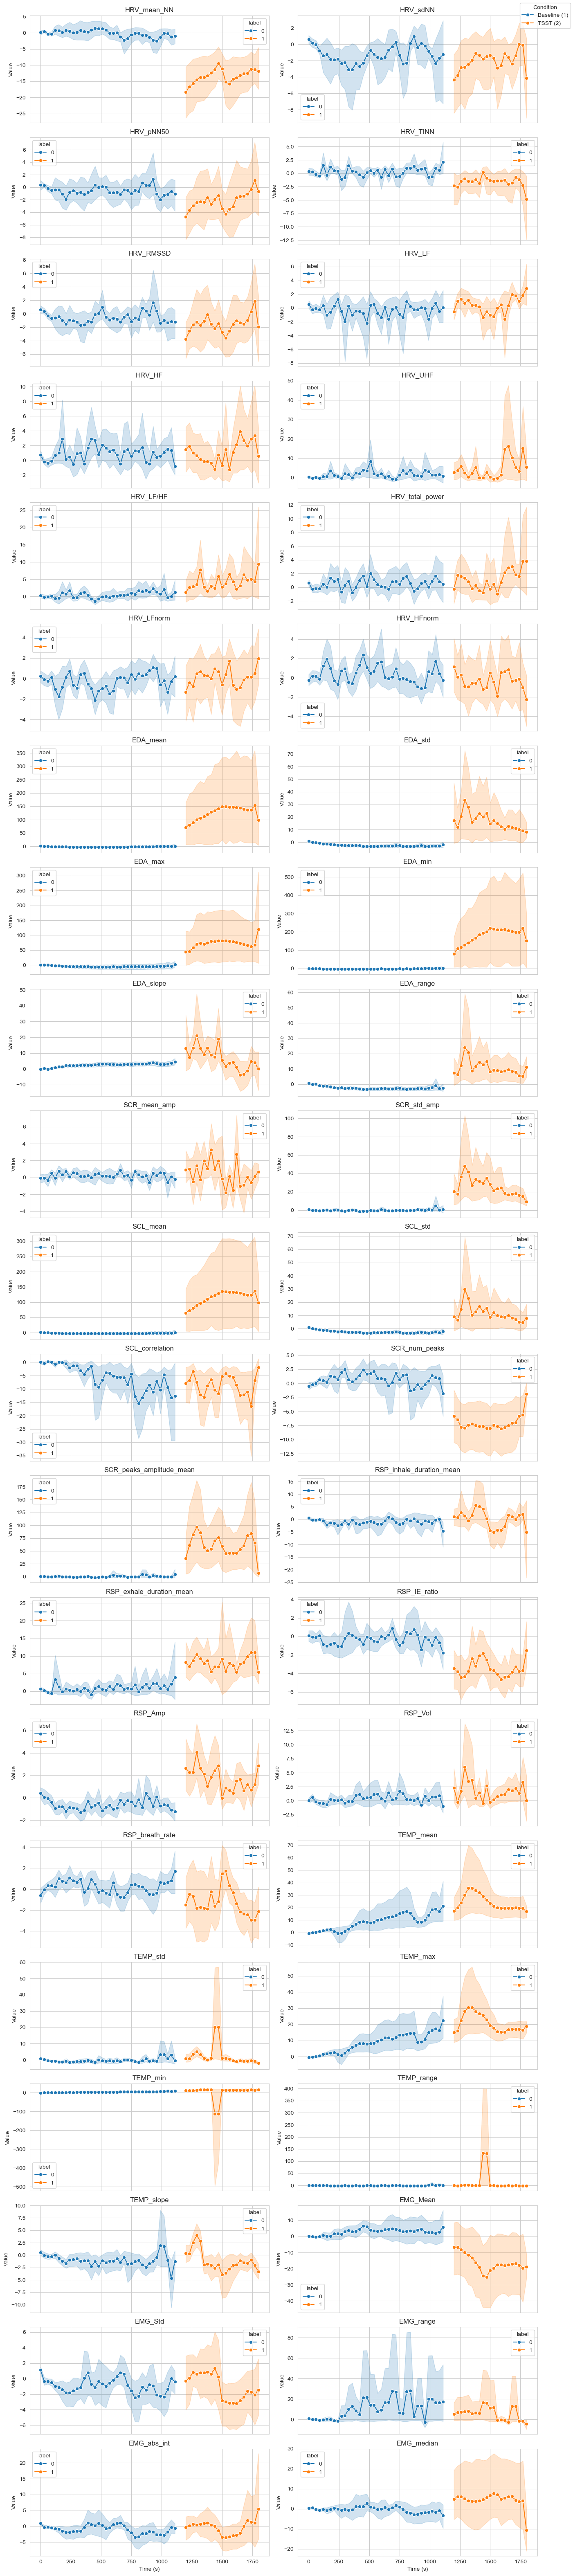

In [25]:
feature_cols = [c for c in train_df.columns if c not in ['label', 'win_start_sec', 'subject','HRV_ULF']]
# Grid layout (2 columns)
n_feats = len(feature_cols)
ncols = 2
nrows = math.ceil(n_feats / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows), sharex=True)
axes = axes.flatten()
for i, feat in enumerate(feature_cols):
    sns.lineplot(data=train_df_calibrate[train_df_calibrate['win_start_sec']<1801], x='win_start_sec', y=feat,ax=axes[i], hue='label', marker='o') # one of the subject's time window is beyond 1800, excluded the section beyond TSST condition
    axes[i].set_title(feat)
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Value")
    #axes[i].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Baseline (1)", "TSST (2)"], title="Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

## Feature plots (uncalibrated)

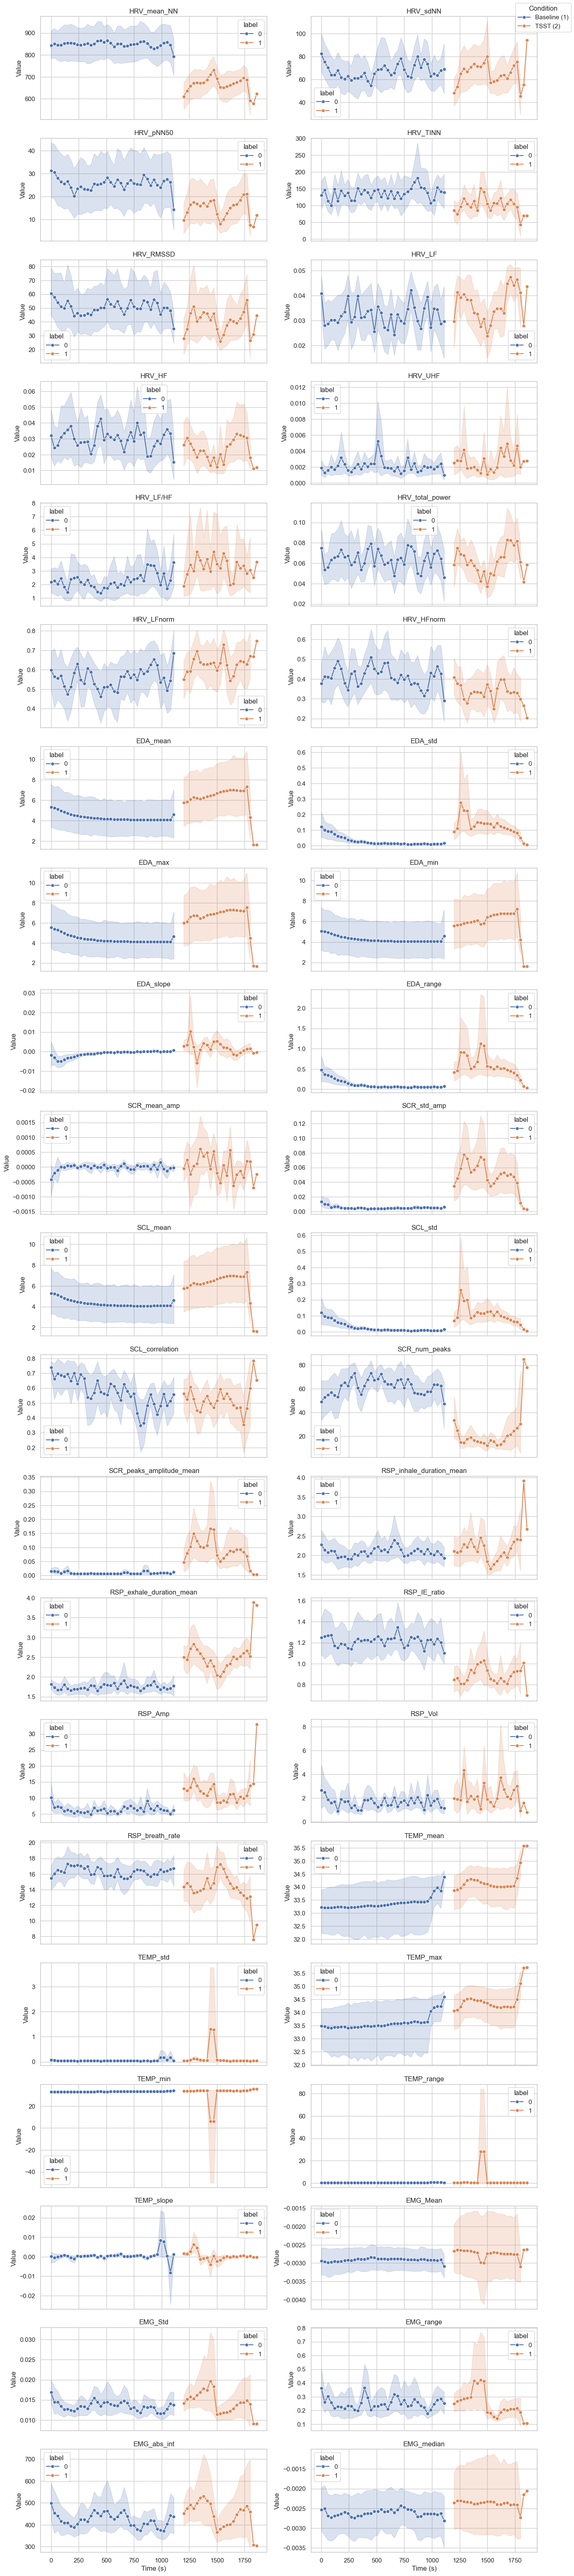

In [ ]:
feature_cols = [c for c in train_df.columns if c not in ['label', 'win_start_sec', 'subject','HRV_ULF']]
# Grid layout (2 columns)
n_feats = len(feature_cols)
ncols = 2
nrows = math.ceil(n_feats / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows), sharex=True)
axes = axes.flatten()
for i, feat in enumerate(feature_cols):
    sns.lineplot(data=train_df, x='win_start_sec', y=feat,ax=axes[i], hue='label', marker='o')
    axes[i].set_title(feat)
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Value")
    #axes[i].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ["Baseline (1)", "TSST (2)"], title="Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()
